In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%reload_ext autoreload
%autoreload 2
import sys, platform, os
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
from getdist.gaussian_mixtures import GaussianND
from getdist import plots, MCSamples
import camb
import random
import getdist
from camb import model, initialpower
import scipy.integrate as integrate
import scipy.integrate as integrate
import cambwrap
from getdist.mcsamples import MCSamplesFromCobaya
import getdist.plots as gdplt
import fishda
from cobaya.run import run
from timeit import default_timer as timer
print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))
# make sure the version and path is what you expect

Using CAMB 1.3.2 installed at C:\ProgramData\Anaconda3\lib\site-packages\camb


In [2]:
#example of setting up params and step in dictionary
#usually take 1 % of the fid value for step

z=0
params={'H0':67.5,'omega_b_h2':0.02239, 'omega_c_h2':0.1178, 'mnu':0.06, 'tau':0.06,'lA_s':3.064, 'n_s':0.695,\
        'theta_scen':None,'Yhe':0.2454006,'w':-1,'wa':0,'omk':0,'omm':0.3,'omlambda':0.7,'test':np.pi/2}
step={'H0':0.3,'omega_b_h2':8e-4, 'omega_c_h2':0.003,'mnu':0.0006, 'tau':0.006,'lA_s':0.03, 'n_s':0.01,\
        'theta_scen':0.01,'Yhe':0.0002454006,'w':0.01,'wa':0.002,'omk':1e-4,'omm':0.003,'omlambda':0.007,'test':0.1}
I=cambwrap.cambwrap(params,z,signal='cmbSO')#cosmic variance cov mat depends on fiducial point cosmology power spectra
fid=np.copy(I.signal)

In [4]:
#initiate the fisher-dali object
fish=fishda.FishDa(params,z,step,0,signal='cmbSO')
#pick the parameters on which you want to forecast
par=['omega_b_h2','omega_c_h2','H0','tau','n_s','lA_s']
#get the first derivative
#1st for 1st stencil
#2nd for 2nd stencil
fish.getfirstderiv(par, params,derivmethod='1st')

In [24]:
np.save('CMBTTTEEE1deriv.npy',fish.firstderiv)#you can save the derivatives as well

In [5]:
#setting up cmb cosmic variance cov mat

ClTTTT=fid[:int(len(fid)/3)]**2
ClTTTE=fid[:int(len(fid)/3)]*fid[int(len(fid)/3):int(len(fid)/3*2)]
ClTTEE=fid[int(len(fid)/3):int(len(fid)/3*2)]**2
ClTETE=fid[:int(len(fid)/3)]*fid[int(len(fid)/3*2):int(len(fid))]+fid[int(len(fid)/3):int(len(fid)/3*2)]**2
ClTEEE=fid[int(len(fid)/3*2):int(len(fid))]*fid[int(len(fid)/3):int(len(fid)/3*2)]
ClEEEE=fid[int(len(fid)/3*2):int(len(fid))]**2
cov=np.array([[ClTTTT,ClTTTE,ClTTEE],[ClTTTE,ClTETE,ClTEEE],[ClTTEE,ClTEEE,ClEEEE]])

In [11]:
#for other signals, you can find the Fisher matrix by calling
#F=fish.fisher(par,derivmethod='1st')

l=np.arange(30,3000,1)
#for CMB, we have a summation over ell, and matrix multiplication in TT TE and EE, so I did it manually here
F=[]

for k1 in par:
    frow=[]
    for k2 in par:
        s=0
        for i in range(len(l)):
            c=cov[:,:,i]
            d1=np.array([fish.firstderiv[k1][i],fish.firstderiv[k1][i+int(len(l))],fish.firstderiv[k1][i+int(len(l)*2)]])
            d2=np.array([fish.firstderiv[k2][i],fish.firstderiv[k2][i+int(len(l))],fish.firstderiv[k2][i+int(len(l)*2)]])
            #print(i+int(len(l)/3*2))
            s+=(2*l[i]+1)*np.einsum('i,ij,j',d1,np.linalg.inv(c),d2)/2
        frow.append(s)
    F.append(np.array(frow))
F=np.array(F)

In [12]:
covariance = np.linalg.inv(F)
mean=np.array([0.02239,0.1178,67.5,0.06,0.965,3.064])
gauss=GaussianND(mean, covariance,names=['omega_b_h2','omega_c_h2','H0','tau','n_s','lA_s'], labels=['omegabh2','omegach2','H0','tau','ns','lAs'])

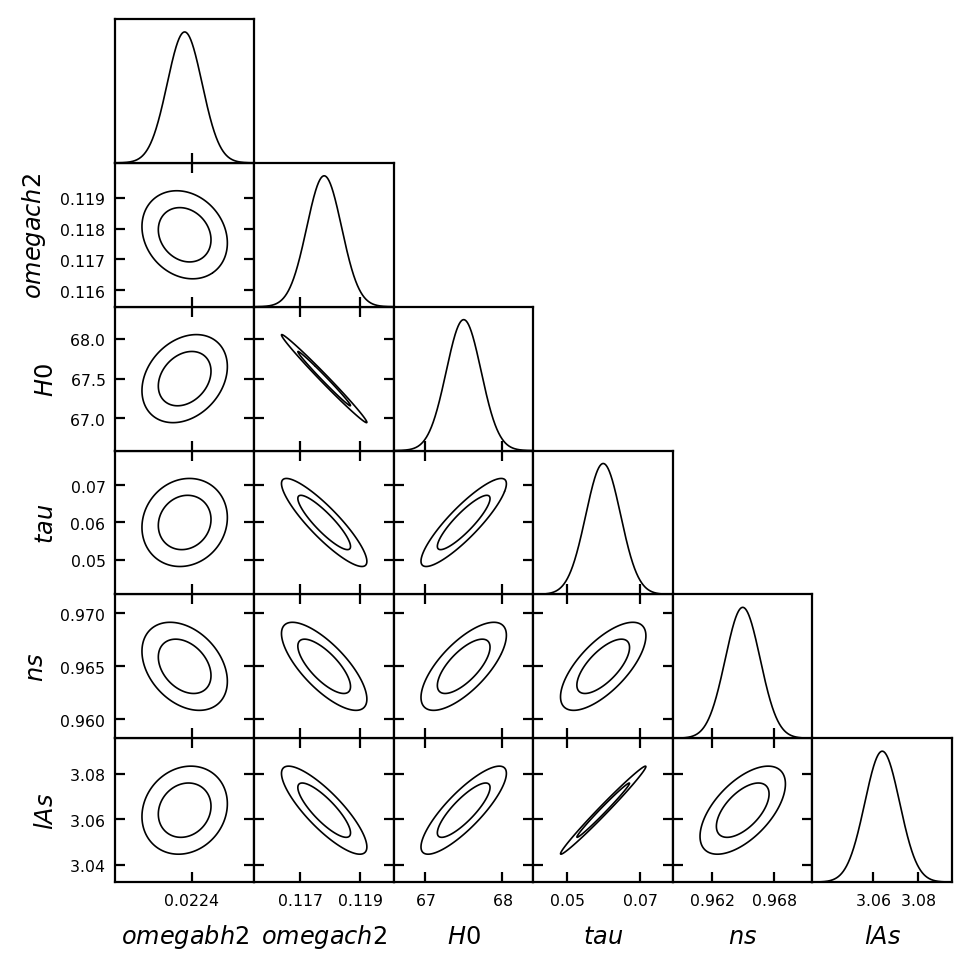

In [13]:

gdplot = gdplt.get_subplot_plotter(width_inch=5)
#gdplot.triangle_plot([gdsamples,gauss,gdsamplesdali], ["omm",'w'], filled=[True,False,False],legend_labels=[r'$1\%$ sn True, cut at z=1', r'$1\%$ sn Fisher, cut at z=1',r'$1\%$ sn DALI, cut at z=1'],contour_lws=[1,2,2],contour_ls= ['-', '--','-.'],contour_colors=['blue','red','green'])
#gdplot.triangle_plot([gdsamples,gauss], ["omm",'w'], filled=[True,False],legend_labels=[r'$1\%$ sn True, cut at z=1', r'$1\%$ sn Fisher, cut at z=1'],contour_lws=[1,2],contour_ls= ['-', '--'],contour_colors=['blue','red'])
gdplot.triangle_plot(gauss)